### import necessary library 

In [3]:
from __future__ import absolute_import, division, print_function
import pathlib

In [4]:
import pandas as pd
import seaborn as sns

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### check version 

In [7]:
print(tf.__version__)

1.12.0


In [8]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


### download the dataset 

In [9]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 1s 15us/step


'C:\\Users\\Tianqin\\.keras\\datasets\\auto-mpg.data'

In [10]:
# use pandas to import the data
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

In [11]:
# take a look at the data
dataset = raw_dataset.copy()
# pandas.dataframe.tail(n) returns the last n rows, default returns the last 5 rows
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### clean the data 

In [13]:
# the dataset contains some unknown values, isna() indicates whether the element is NA value
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [14]:
# Let's simply drop the unknown terms
dataset = dataset.dropna()

In [15]:
# The "Origin" column is categorical, not numeric. So convert that to a one-hot:
# pop: Return item and drop from frame
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### split the data into train and test 

In [17]:
# use 80% dataset for training and 20% for testing
train_dataset = dataset.sample(frac=0.8,random_state=0)
# test set is dataset without trainset
test_dataset = dataset.drop(train_dataset.index)

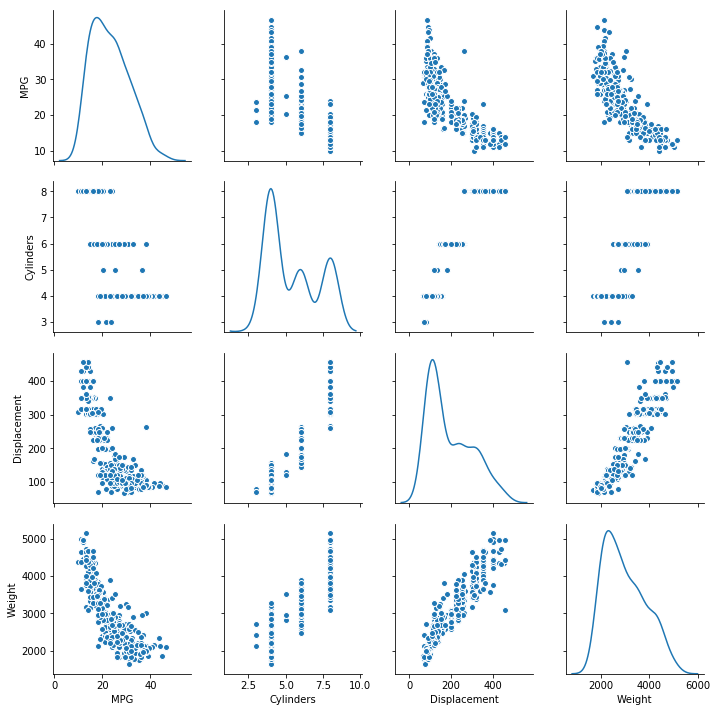

In [18]:
# take a look at the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [20]:
# take a look at the overall statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [21]:
# split features from labels
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data 

In [22]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### Build the model 

If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.

In [25]:
# we'll use a Sequential model with two densely connected hidden layers, 
# and an output layer that returns a single, continuous value.

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  # Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
  # Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [26]:
model = build_model()

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Now try out the model. Take a batch of 10 exampes from the training data and call model.predict on it.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.3479566 ],
       [ 0.13026719],
       [ 0.10719034],
       [ 0.11080141],
       [ 0.9734689 ],
       [-0.13611168],
       [ 1.0919952 ],
       [ 0.10455536],
       [-0.0310704 ],
       [ 0.9961008 ]], dtype=float32)

It seems to be working, it produces a result of the expected shape and type.

### Train the model 

The model is trained for 1000 epochs, and record the training and validation accuracy in the history object.

In [29]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [30]:
# visualize the model's training progress using the stats stored in the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,1.978907,0.919669,1.978907,9.279453,2.413544,9.279453,995
996,2.230411,0.952595,2.230411,8.943562,2.398819,8.943562,996
997,1.966385,0.919097,1.966385,8.551974,2.367031,8.551974,997
998,2.161633,0.969373,2.161633,9.097521,2.392797,9.097521,998
999,1.943196,0.916033,1.943196,9.026233,2.420282,9.026233,999


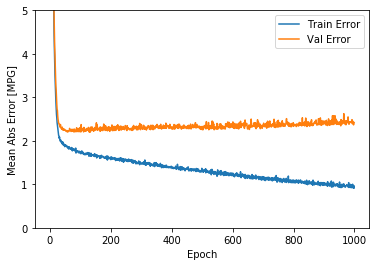

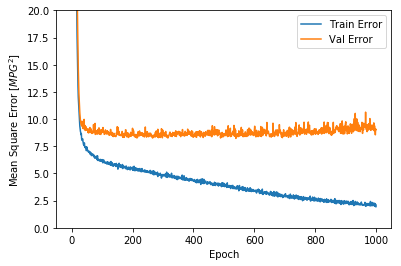

In [31]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)

Let's update the model.fit method to automatically stop training when the validation score doesn't improve. We'll use a callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.


....................................................................................................
....................................................................................................
..................................................

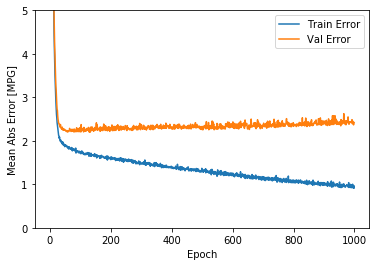

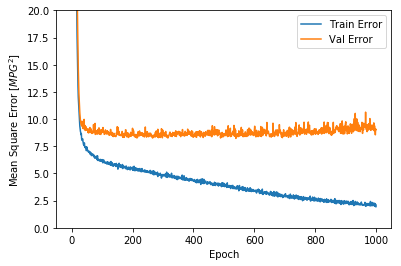

In [32]:
# If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
Early stopping is a useful technique to prevent overfitting.
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.02 MPG


### Make Predictions 

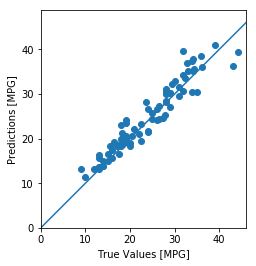

In [34]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

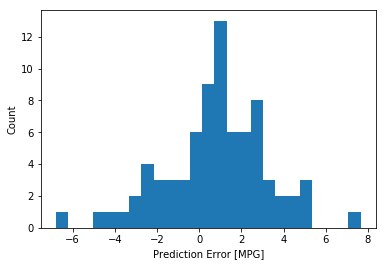

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")